#Importing Packages

* os - used to read files and directory structure
* numpy - used to convert python list to numpy array for performing matrix operations
* matplotlib.pyplot - used to plot the graph and display images in our training and validation data

In [1]:
import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Data Loading
We need to download the flower dataset. We will first download the archived version of the dataset and after the download we are storing it to "/tmp/" directory. After downloading it we will extract its contents.

In [2]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(
    origin=_URL,
    fname="flower_photos.tgz",
    extract=True
)

base_dir = os.path.join(os.path.dirname(zip_file), "flower_photos")

228818944/228813984 [==============================] - 2s 0us/step


The dataset we downloaded contains images of 5 types of flowers:

1. Rose
2. Daisy
3. Dandelion
4. Sunflowers
5. Tulips

So, let's create the labels for these 5 classes: 

In [3]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

In [4]:
zip_dir_base = os.path.dirname(zip_file)
!find $zip_dir_base -type d -print

/root/.keras/datasets
/root/.keras/datasets/flower_photos
/root/.keras/datasets/flower_photos/roses
/root/.keras/datasets/flower_photos/dandelion
/root/.keras/datasets/flower_photos/tulips
/root/.keras/datasets/flower_photos/daisy
/root/.keras/datasets/flower_photos/sunflowers


As we can see there are no folders containing training and validation data, therefore we will have to create our own training and validation set.

The code below creates a `train` and `val` folder, each containing 5 folders, one for each class. It moves the images from the original folders to these new folders such that 80% of the images go to the training set and 20% of the images go into the validation set.

In [5]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  train, val = images[:round(len(images)*0.8)], images[round(len(images)*0.8):]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

roses: 641 Images
daisy: 633 Images
dandelion: 898 Images
sunflowers: 699 Images
tulips: 799 Images


For convenience, let us set up the path for the training and validation sets.

In [6]:
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")

#Data Augmentation

Overfitting occurs when we have small number of training examples. One way to fix this problem is to augment our dataset to increase our number of training examples. Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, the model will never see the same picture twice. This helps the model to generalize better, by exposing it to more aspects of data.

Before making transformations we need to define our `batch size` and `image size`. Don't forget that the input to our CNN are images of the same size, therefore we need to resize the images in our dataset to the same size.

In [7]:
BATCH_SIZE = 1000
IMG_SHAPE = 150

In the cell below, we use `ImageDataGenerator` to create a transformation that rescales the images by 255 and that applies:

* random 45 degree rotation
* random zoom up to 50%
* random horizontal flip
* width shift of 0.15
* height shift of 0.15

We then use `.flow_from_directory` method to apply the above transformations to the images in our training set. Don't forget to indicate the batch size, the path to the directory of the training images, the target size for the images, to shuffle the images, and to set the class mode to `sparse`.

In [8]:
image_gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.5,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_data_gen = image_gen_train.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_SHAPE,IMG_SHAPE),
    class_mode="sparse"
)

Found 2935 images belonging to 5 classes.


We can now visualize how a single image would look like 5 different times, when we pass these augmentations randomly to our dataset.

In [9]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

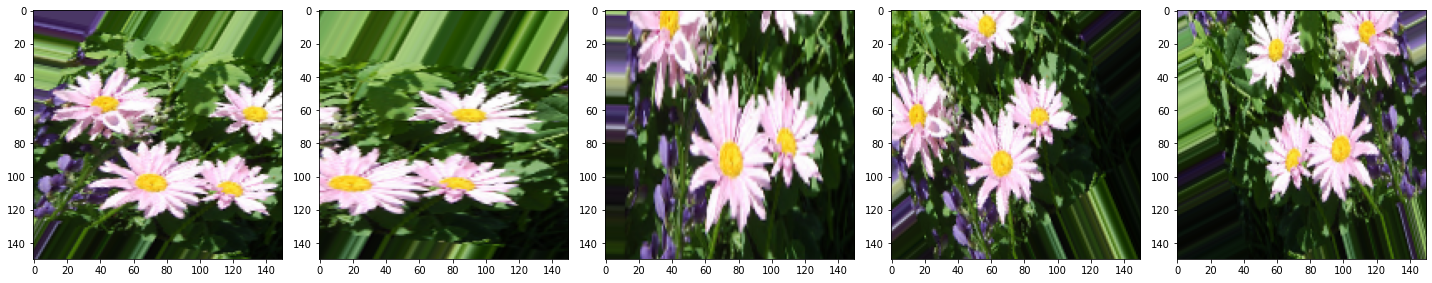

In [10]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

Generally, we only apply data augmentation to our training examples. So, in the cell below we use ImageDataGenerator to create a transformation that only rescales the images by 255, afterwards we apply the above transformations to the images in our validation set.

In [11]:
image_gen_val = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.5,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_data_gen = image_gen_val.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=val_dir,
    target_size=(IMG_SHAPE,IMG_SHAPE),
    class_mode="sparse"
)

Found 735 images belonging to 5 classes.


#Create the CNN
Below we create a convolutional neural network consisting of 3 convolution blocks. Each convolution block contains a `Conv2D` layer followed by a max pool layer. The first convolutional layer should have 16 filters, the second should have 32 filters and the third one should have 64 filters. All filters should be 3 x 3 and all max pool layers should have a `pool_size` of 2 x 2.

After the 3 convolutional blocks you should have a flatten layer followed by a fully connected layer with 512 units. The CNN should output class probabilities based on 5 classes which is done by the `softmax` activation function, whilst all other layers should use a `relu` activation function. A Dropout layer should be added as well with a probability of 20%.

In [12]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(16, (3,3), activation="relu", input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
                                    tf.keras.layers.MaxPooling2D(2,2),

                                    tf.keras.layers.Conv2D(32, (3,3), activation="relu"),
                                    tf.keras.layers.MaxPooling2D(2,2),

                                    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
                                    tf.keras.layers.MaxPooling2D(2,2),

                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(512, activation="relu"),
                                    
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(5)
])

#Compile the model
We compile the model using the `ADAM` optimizer, the `sparse categorical crossentropy` function will be used as a loss function. We would also like to look at training and validation accuracy on each epoch as we train our network, so we must make sure the metrics argumets is passed.

In [13]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

#Train the model
We must use the `fit_generator` instead of using `fit` function because we are using the `ImageDataGenerator` class to generate batches of training and validation data for our model. We are training the model for 80 epochs.

In [14]:
EPOCHS=80
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n/float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n/float(BATCH_SIZE)))
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/80
3/3 [==============================] - 34s 9s/step - loss: 2.3252 - accuracy: 0.2144 - val_loss: 1.8277 - val_accuracy: 0.2558
Epoch 2/80
3/3 [==============================] - 25s 9s/step - loss: 1.7361 - accuracy: 0.2395 - val_loss: 1.5717 - val_accuracy: 0.2177
Epoch 3/80
3/3 [==============================] - 24s 9s/step - loss: 1.5536 - accuracy: 0.2775 - val_loss: 1.4965 - val_accuracy: 0.3102
Epoch 4/80
3/3 [==============================] - 24s 9s/step - loss: 1.4588 - accuracy: 0.3655 - val_loss: 1.3820 - val_accuracy: 0.3864
Epoch 5/80
3/3 [==============================] - 24s 9s/step - loss: 1.3479 - accuracy: 0.4048 - val_loss: 1.3034 - val_accuracy: 0.4340
Epoch 6/80
3/3 [==============================] - 24s 9s/step - loss: 1.2738 - accuracy: 0.4508 - val_loss: 1.3449 - val_accuracy: 0.4286
Epoch 7/80
3/3 [==============================] - 24s 9s/step - loss: 1.2669 - accuracy: 0.4587 - val_loss: 1.2645 - val_accuracy: 0.4517
Epoch 8/80
3/3 [==================

#Plot training and validation graphs


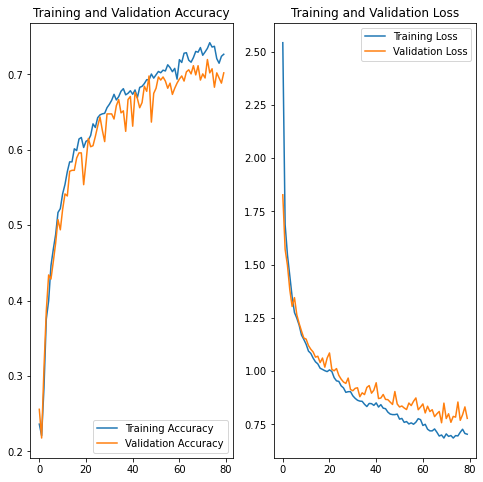

In [25]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

EPOCHS_RANGE = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(EPOCHS_RANGE, acc, label='Training Accuracy')
plt.plot(EPOCHS_RANGE, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(EPOCHS_RANGE, loss, label='Training Loss')
plt.plot(EPOCHS_RANGE, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()